In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
import plotly.express as px

In [31]:
data = pd.read_csv('data/NYC_Motor_Vehicle_Collisions_Cleaned.csv')

In [32]:
data['crash_datetime'] = pd.to_datetime(data['crash_datetime'], errors='coerce')

/var/folders/h1/9jjzk_qj1l19pnl_kwfs0pwc0000gn/T/ipykernel_42848/2592208115.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='borough', order=data['borough'].value_counts().index, palette='viridis')


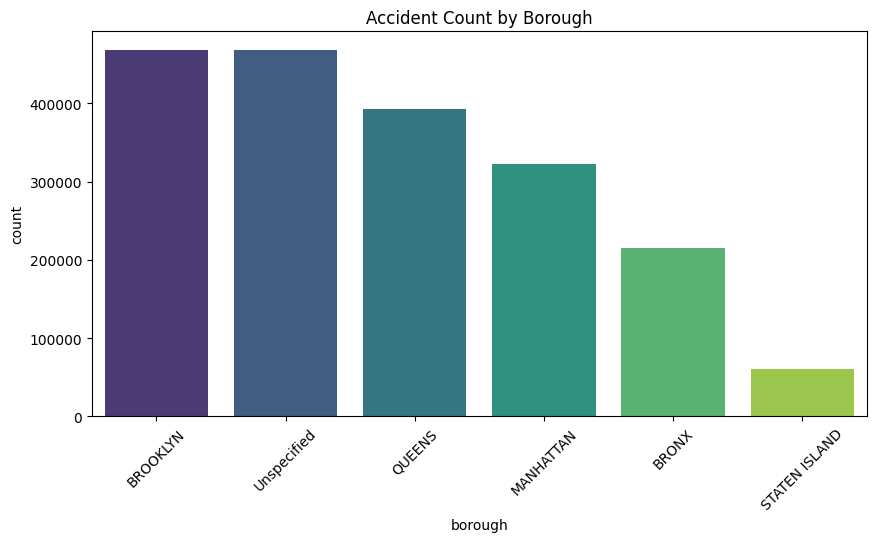

In [33]:
# Borough-wise accident count
plt.figure(figsize=(10,5))
sns.countplot(data=data, x='borough', order=data['borough'].value_counts().index, palette='viridis')
plt.title('Accident Count by Borough')
plt.xticks(rotation=45)
plt.show()

### Some Feature Engineering

In [34]:
# Extract more granular datetime features
data['month'] = data['crash_datetime'].dt.month
data['day_of_week'] = data['crash_datetime'].dt.day_name()
data['hour'] = data['crash_datetime'].dt.hour
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday'])

In [35]:
def classify_severity(row):
    if row['number_of_persons_killed'] > 0:
        return 'Fatal'
    elif row['number_of_persons_injured'] > 0:
        return 'Injury'
    else:
        return 'Property Damage Only'

data['severity'] = data.apply(classify_severity, axis=1)

In [36]:
data['total_casualties'] = data['number_of_persons_killed'] + data['number_of_persons_injured']

In [37]:
data['is_night'] = data['hour'].apply(lambda x: x < 6 or x > 20)

### Plots

/var/folders/h1/9jjzk_qj1l19pnl_kwfs0pwc0000gn/T/ipykernel_42848/4054745014.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='severity', palette='Set2')


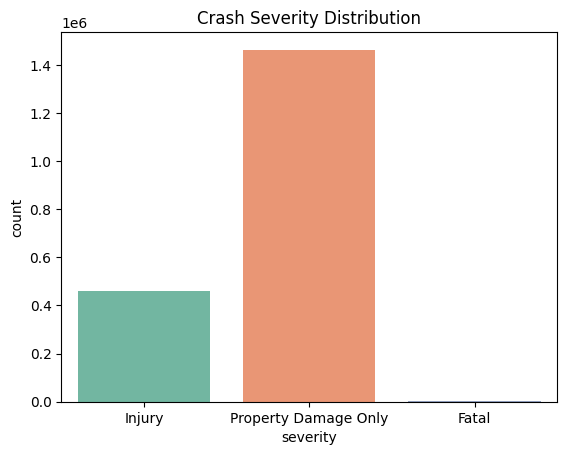

In [38]:
sns.countplot(data=data, x='severity', palette='Set2')
plt.title("Crash Severity Distribution")
plt.show()

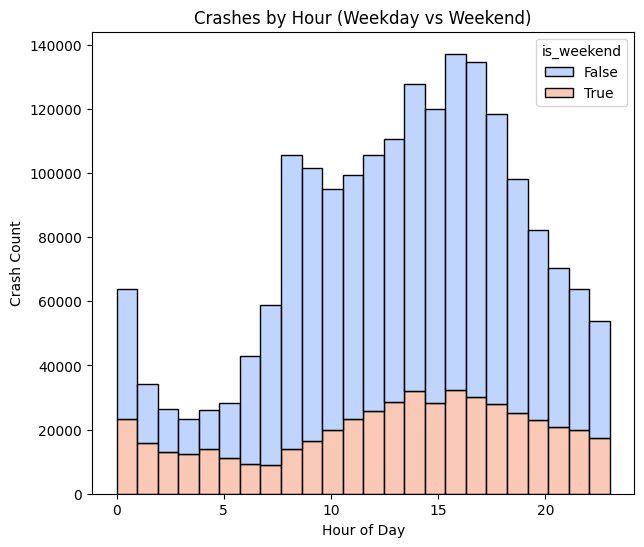

In [50]:
plt.figure(figsize=(7,6))
sns.histplot(data=data, x='hour', hue='is_weekend', multiple='stack', palette='coolwarm', bins=24)
plt.title("Crashes by Hour (Weekday vs Weekend)")
plt.xlabel("Hour of Day")
plt.ylabel("Crash Count")
plt.show()

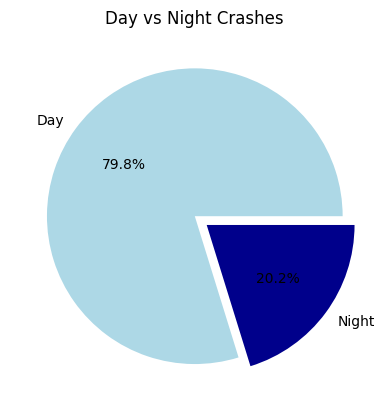

In [40]:
night_day_counts = data['is_night'].value_counts()
night_day_counts.index = ['Day', 'Night']
night_day_counts.plot.pie(autopct='%1.1f%%', colors=['lightblue', 'darkblue'], explode=(0,0.1))
plt.title("Day vs Night Crashes")
plt.ylabel('')
plt.show()

/var/folders/h1/9jjzk_qj1l19pnl_kwfs0pwc0000gn/T/ipykernel_42848/1390320830.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=data, order=[


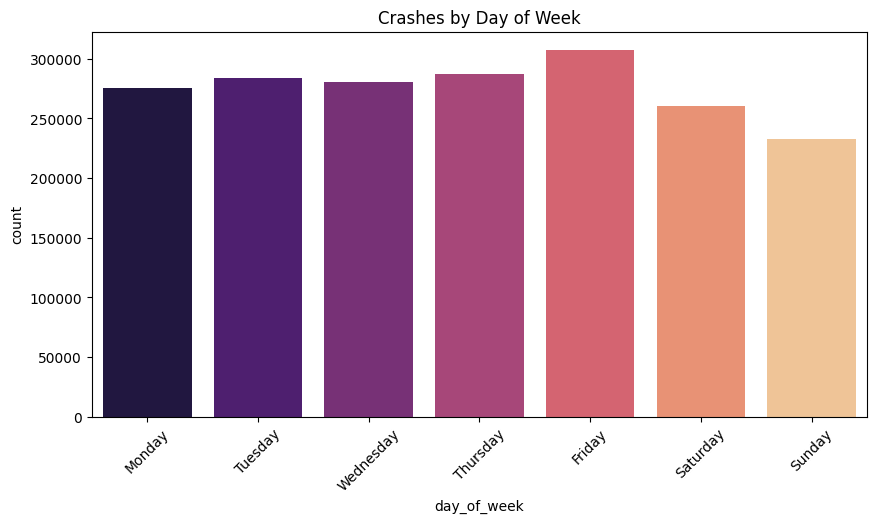

In [41]:
# Crashes by day of week
plt.figure(figsize=(10,5))
sns.countplot(x='day_of_week', data=data, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='magma')
plt.title('Crashes by Day of Week')
plt.xticks(rotation=45)
plt.show()

/var/folders/h1/9jjzk_qj1l19pnl_kwfs0pwc0000gn/T/ipykernel_42848/1323779955.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month', data=data, palette='viridis')


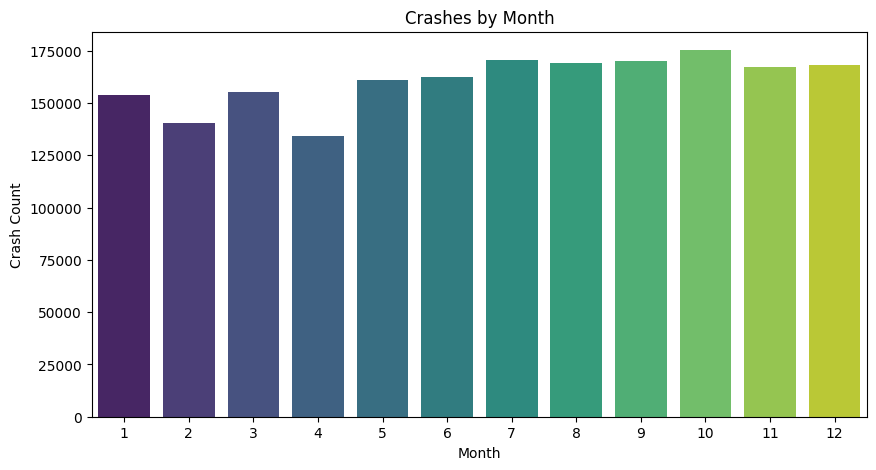

In [42]:
# Crashes by month
plt.figure(figsize=(10,5))
sns.countplot(x='month', data=data, palette='viridis')
plt.title('Crashes by Month')
plt.xlabel('Month')
plt.ylabel('Crash Count')
plt.show()

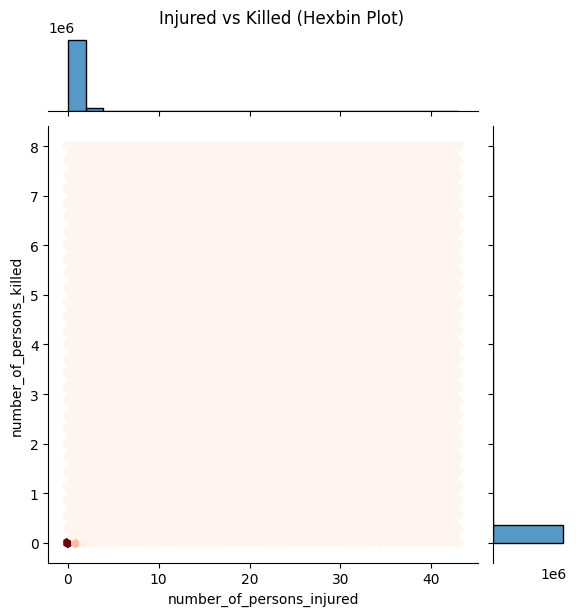

In [43]:
# Distribution of persons injured/killed
person_cols = ['number_of_persons_injured', 'number_of_persons_killed']
data[person_cols].describe()

# Injured vs killed correlation
sns.jointplot(x='number_of_persons_injured', y='number_of_persons_killed', data=data, kind='hex', cmap='Reds')
plt.suptitle('Injured vs Killed (Hexbin Plot)', y=1.02)
plt.show()

/var/folders/h1/9jjzk_qj1l19pnl_kwfs0pwc0000gn/T/ipykernel_42848/3058877710.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_factors.index, y=top_factors.values, palette='coolwarm')


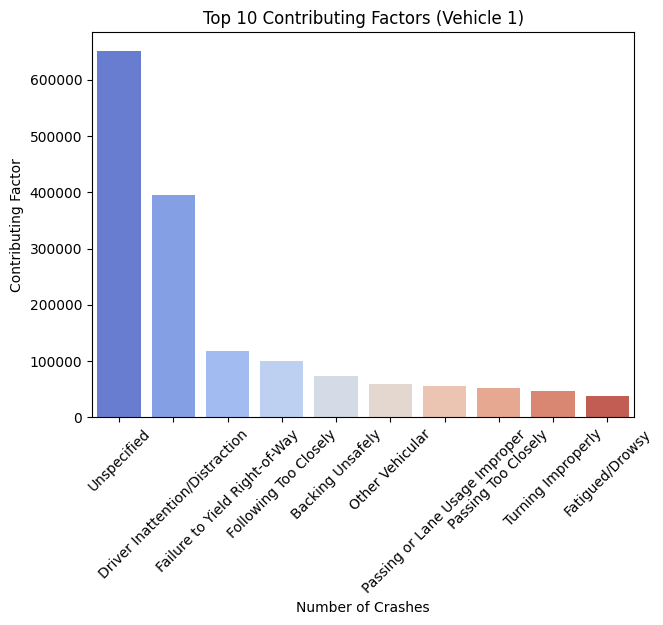

In [49]:
# Top contributing factors for driver
top_factors = data['contributing_factor_vehicle_1'].value_counts().nlargest(10)
plt.figure(figsize=(7,5))
sns.barplot(x=top_factors.index, y=top_factors.values, palette='coolwarm')
plt.title('Top 10 Contributing Factors (Vehicle 1)')
plt.xlabel('Number of Crashes')
plt.xticks(rotation=45) 
plt.ylabel('Contributing Factor')
plt.show()

In [12]:
# Filter for valid coordinates
crash_map_data = data[['latitude', 'longitude']].dropna()

# Heatmap
m = folium.Map(location=[crash_map_data['latitude'].mean(), crash_map_data['longitude'].mean()], zoom_start=11)
HeatMap(data=crash_map_data.values, radius=10).add_to(m)
m.save('crash_heatmap.html')

In [14]:
# Filter valid coordinates
crash_map_data = data[['latitude', 'longitude', 'crash_datetime']].dropna().sample(1000, random_state=42)  # sample for performance

# Base map
m = folium.Map(location=[crash_map_data['latitude'].mean(), crash_map_data['longitude'].mean()], zoom_start=11)

# Marker Cluster
marker_cluster = MarkerCluster().add_to(m)
for idx, row in crash_map_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Crash Date: {row['crash_datetime']}"
    ).add_to(marker_cluster)

m.save('crash_marker_cluster_map.html')

In [25]:
weighted_heat_data = data[['latitude', 'longitude', 'total_casualties']].dropna().values.tolist()

m2 = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=11)
HeatMap(weighted_heat_data, radius=8, blur=15, max_zoom=13).add_to(m2)

m2.save("heatmap_weighted_by_casualties.html")

In [15]:
def get_severity_color(row):
    if row['number_of_persons_killed'] > 0:
        return 'red'
    elif row['number_of_persons_injured'] > 0:
        return 'orange'
    else:
        return 'blue'

# Subset and assign color
map_data = data[['latitude', 'longitude', 'number_of_persons_killed', 'number_of_persons_injured']].dropna().sample(500, random_state=1)
map_data['color'] = map_data.apply(get_severity_color, axis=1)

m = folium.Map(location=[map_data['latitude'].mean(), map_data['longitude'].mean()], zoom_start=11)

for _, row in map_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=row['color'],
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m.save("severity_map.html")

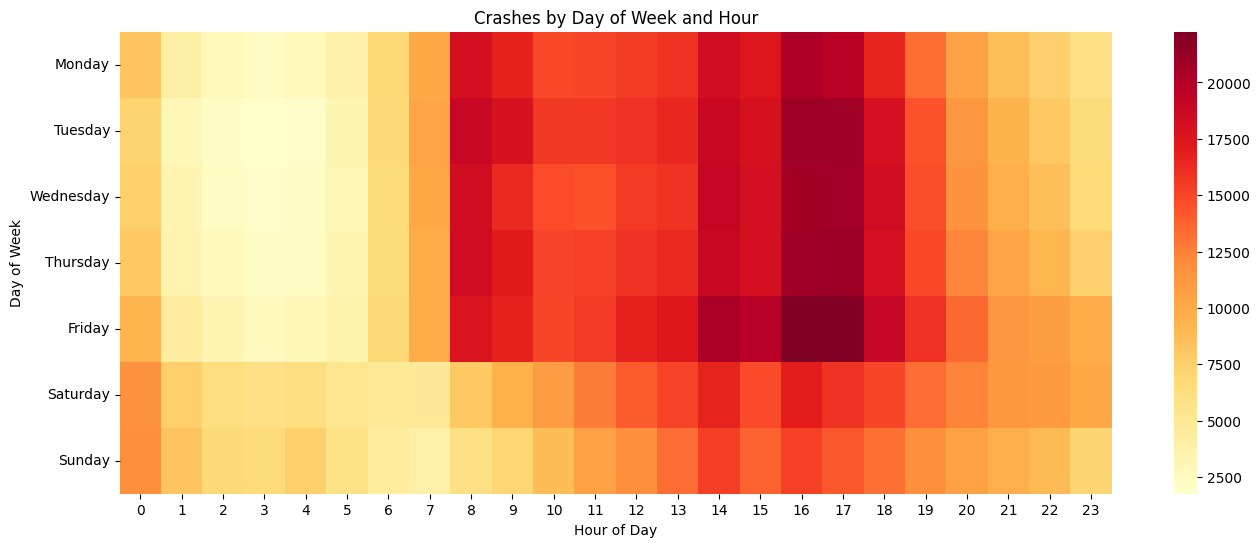

In [39]:
# Pivot table
pivot_table = data.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)
# Ensure correct order
pivot_table = pivot_table.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.figure(figsize=(16,6))
sns.heatmap(pivot_table, cmap='YlOrRd')
plt.title('Crashes by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

### Some Multivariate Analysis

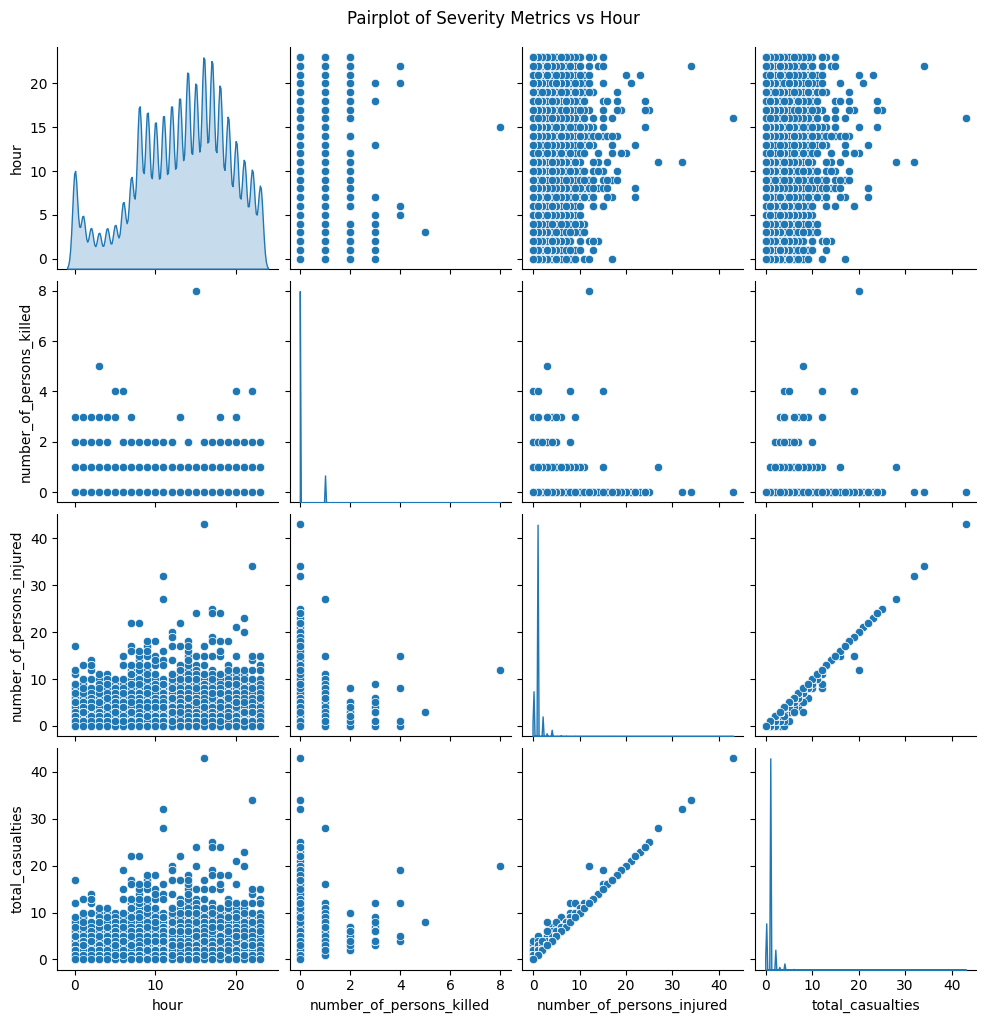

In [26]:
sns.pairplot(data[['hour', 'number_of_persons_killed', 'number_of_persons_injured', 'total_casualties']], diag_kind='kde')
plt.suptitle("Pairplot of Severity Metrics vs Hour", y=1.02)
plt.show()

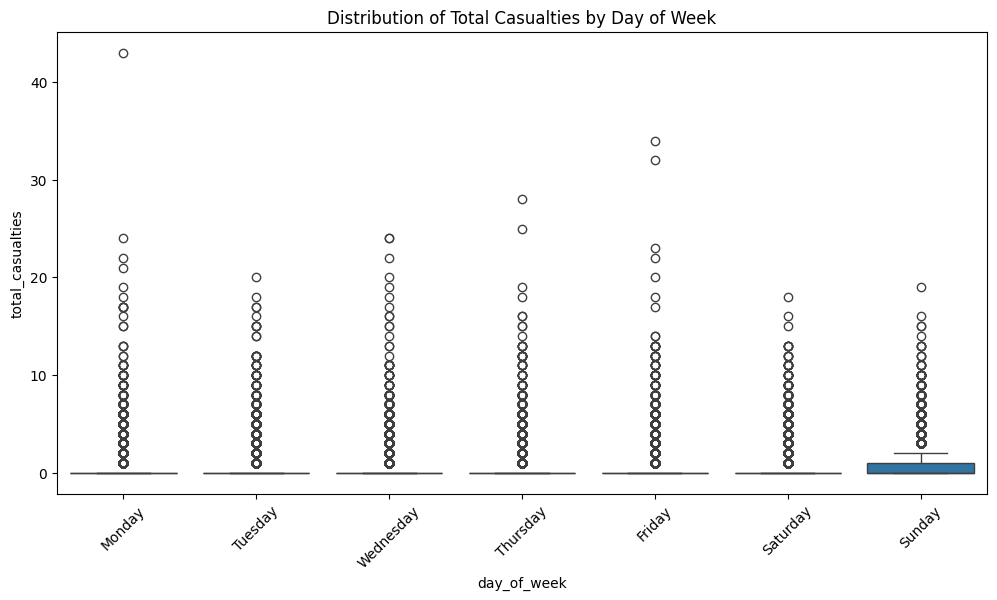

In [27]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x='day_of_week', y='total_casualties', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Distribution of Total Casualties by Day of Week")
plt.xticks(rotation=45)
plt.show()

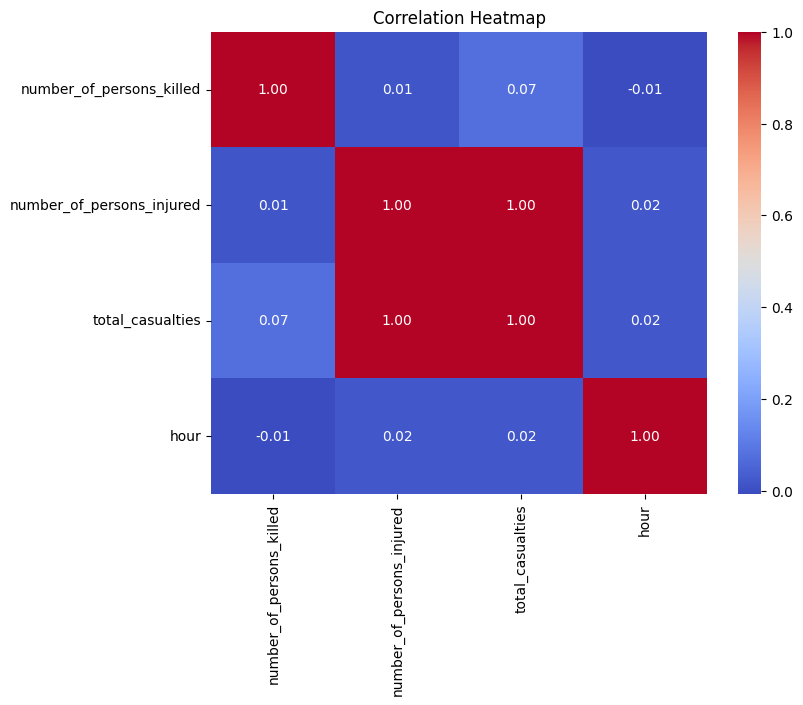

In [28]:
numeric_cols = ['number_of_persons_killed', 'number_of_persons_injured', 'total_casualties', 'hour']
corr = data[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

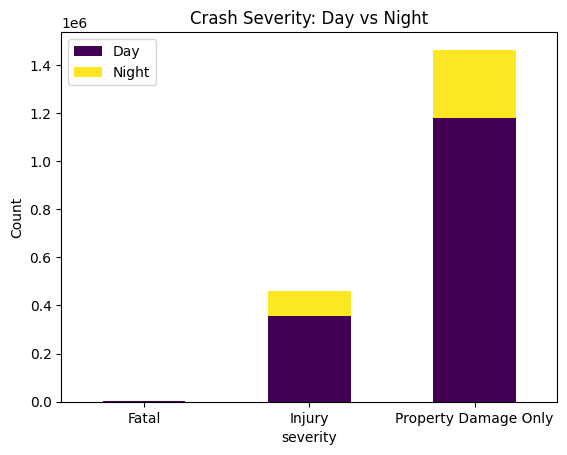

In [29]:
severity_night = pd.crosstab(data['severity'], data['is_night'])
severity_night.columns = ['Day', 'Night']
severity_night.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Crash Severity: Day vs Night")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()